# Задача 5. Экспериментальное исследование алгоритмов для регулярных запросов
# Автор: [Miroshnikov Vladislav](https://github.com/vladislav-miroshnikov)
## Введение

Задача посвящена анализу производительности различных реализаций алгоритма решения задачи достижимости между всеми парами вершин с регулярными ограничениями через тензорное произведение.

Перейдем к постановке задачи:

В задаче имеется размеченный граф $G$, допускающий регулярный язык $L_G$, то есть конечный автомат, эквивалентный данному графу, допускает этот же язык $L_G$.

Также имеется регулярное выражение $R$, которое задает регулярный язык $L_R$, который мы считаем нашим языком ограничений.

Рассмотрим задачу $RPQ = \{(v_i, v_j)|\exists\pi:w(v_i\pi v_j)\in L, v_i\in V_S, v_j\in V_F\}$, где $L = L_G\cap L_R$

Чтобы построить язык пересечения, нужно построить пересечение конечных автоматов $КА_{G}$ и $КА_{R}$.

Введем определение пересечения конечных автоматов:

$КА_3 = КА_1\cap КА_2 = (S^{1}\times S^{2}, \Delta^{3}, S^{1}_S\times S^{2}_S, S^{1}_F\times S^{2}_F)$, где функция переходов задаётся как
$\Delta^{3}: (v_i, v_j)\times l\rightarrow (u_i, u_j)$

$
\begin{cases}
v_i\in S^{1}\times l\rightarrow u_i\in S^{1}\quad\in\Delta^{1} \\
v_j\in S^{2}\times l\rightarrow u_j\in S^{2}\quad\in\Delta^{2}
\end{cases}$

Построение функции переходов осуществляется через тензорное произведении матриц смежностей конечных автоматов. 

## Постановка задачи
### Цели и задачи
Целью данного исследования является проведение эксперимента, основанного на осуществлении регулярных запросов к набору графов в двух вариантах реализации алгоритма пересечения конечных автоматов с дальнейшим анализом полученных результатов.

Для достижения цели необходимо:
- Используя библиотеку pyCuBool, основанную на технологии NVIDIA CUDA,  реализовать алгоритм пересечения двух конечных автоматов через тензорное произведение
- Взять ранее реализованный алгоритм для пересечения двух конечных автоматов через тензорное произведение
- Сформировать и описать набор данных для экспериментов
- Сформулировать методологию проведения эксперимента
- Произвести сравнительный анализ производительности реализаций алгоритмов


## Исследуемые решения
Элементами матрицы смежности конечного автомата являются подмножества его меток. Чтобы не вводить операцию пересечения множеств в тензорном произведении, мы будем приводить матрицы смежности двух конечных автоматов к виду булевых матриц.

Булевы матрицы на практике являются сильно разреженными. Для работы с подобными разреженными матрицами мы будем использовать алгоритм в двух вариантах реализации, основанный на следующих библиотеках: 
- [pyCuBool](https://pypi.org/project/pycubool/)
- [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html)


**Ограничения**: В scipy.sparce используются матрицы типа `dok`, в pyCuBool – матрицы для вычислений на GPU.



## Настройка и инициализация рабочего окружения

Установка библиотеки pycubool

In [2]:
!pip install pycubool

     |████████████████████████████████| 1.5 MB 5.2 MB/s 


### Для работы с алгоритмом, основанным на scipy.sparce, подключим соответствующее решение

Скачивание и установка проекта https://github.com/vladislav-miroshnikov/formal-lang-course

In [3]:
!git clone https://github.com/vladislav-miroshnikov/formal-lang-course

Cloning into 'formal-lang-course'...
remote: Enumerating objects: 377, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 377 (delta 73), reused 62 (delta 53), pack-reused 270
Receiving objects: 100% (377/377), 832.35 KiB | 7.24 MiB/s, done.
Resolving deltas: 100% (163/163), done.


Установка зависимостей проекта

In [5]:
!pip install --upgrade pip
!pip install -r formal-lang-course/requirements.txt

Подключение директории проекта

In [6]:
import sys
sys.path.insert(1, 'formal-lang-course')

### Библиотеки для анализа данных

Для работы с таблицами и графиками подключим библиотеки **pandas** и **seaborn**. 
В ячейке ниже проводится их установка.

In [7]:
!pip install pandas
!pip install seaborn

## Описание данных для экспериментов


### Графы

В качестве $L_G$ будем использовать графы из [RDF](https://jetbrains-research.github.io/CFPQ_Data/dataset/RDF.html) датасета.

Приведем информаци о графах, которые будут использоваться в задаче:

In [8]:
GRAPHS = (
    "skos",
    "generations",
    "travel",
    "univ_bench",
    "atom_primitive",
    "biomedical_mesure_primitive",
    "foaf",
    "people_pets",
    "funding",
    "wine",
    "pizza",
    "core",
    "pathways",
    "enzyme",
    "eclass_514en",
    "go_hierarchy",
    "go",
    "geospecies",
)

**Пределы возможностей**: 

Стоит отметить, что в данный список не вошли графы taxonomy, taxonomy_hierarchy, поскольку вычислительных возможностей Google Colab - среды выполнения, недостаточно для обработки этих графов.

In [9]:
from project import get_graph_info_util

import pandas as pd

e_counts = []
n_counts = []
for graph_name in GRAPHS:
  graph_info = get_graph_info_util(graph_name)
  nodes, edges = graph_info.nodes, graph_info.edges
  e_counts.append(edges)
  n_counts.append(nodes)
  
df = pd.DataFrame(
    {
      "Edges count": e_counts,
      "Nodes count": nodes
    },
    index=GRAPHS
)
df

file:///usr/local/lib/python3.7/dist-packages/cfpq_data/data/RDF/Graphs/<http:/sw.opencyc.org/concept/Mx4rvVi495wpEbGdrcN5Y29ycA> does not look like a valid URI, trying to serialize this will break.
file:///usr/local/lib/python3.7/dist-packages/cfpq_data/data/RDF/Graphs/<http:/sw.opencyc.org/concept/Mx4rvVi495wpEbGdrcN5Y29ycA> does not look like a valid URI, trying to serialize this will break.


,Edges count,Nodes count
skos,252,450609
generations,273,450609
travel,277,450609
univ_bench,293,450609
atom_primitive,425,450609
biomedical_mesure_primitive,459,450609
foaf,631,450609
people_pets,640,450609
funding,1086,450609
wine,1839,450609


Отметим, что здесь строковый вывод информации происходит из-за функции **get_graph_info_util**

## Регулярные запросы

Ниже приведены регулярные запросы, которые будут производится к наборам наших графов. 

Данные запросы используют все общепринятые конструкции регулярных выражений (замыкание, конкатенация, звезда Клини):



1.   $L_1 (L_2 |\ L_3)^*$ 
2.   $L_1^* (L_2 |\ L_3)^*$
3.   $L_0 L_1 L_2 (L_3 |\ L_1)^*$
4.   $(L_0 |\ L_3)^* |\ (L_1 |\ L_2)^*$



In [10]:
from pyformlang.regular_expression.regex_objects import Symbol

def regex_from_label(label):
  regex = Regex("")
  regex.head = Symbol(str(label))
  return regex

def regex_first(labels):
  """
  l1 (l2 | l3)*
  """
  regex_1 = regex_from_label(labels[0])
  regex_2 = regex_from_label(labels[1])
  regex_3 = regex_from_label(labels[2])
  return regex_1.concatenate((regex_2.union(regex_3)).kleene_star())

def regex_second(labels):
  """
   l1* (l2 | l3)*
  """
  regex_1 = regex_from_label(labels[0])
  regex_2 = regex_from_label(labels[1])
  regex_3 = regex_from_label(labels[2])
  return regex_1.kleene_star().concatenate((regex_2.union(regex_3).kleene_star()))

def regex_third(labels):
  """
  l0 l1 l2 (l3 | l1)*
  """ 
  regex_0 = regex_from_label(labels[0])
  regex_1 = regex_from_label(labels[1])
  regex_2 = regex_from_label(labels[2])
  regex_3 = regex_from_label(labels[3])
  return regex_0.concatenate(regex_1).concatenate(regex_2).concatenate((regex_3.union(regex_1)).kleene_star())

def regex_fourth(labels):
  """
  (l0 | l3)* | (l1 | l2)*
  """
  regex_0 = regex_from_label(labels[0])
  regex_1 = regex_from_label(labels[1])
  regex_2 = regex_from_label(labels[2])
  regex_3 = regex_from_label(labels[3])
  left_regex = (regex_0.union(regex_3)).kleene_star()
  right_regex = (regex_1.union(regex_2)).kleene_star()
  return left_regex.union(right_regex)

## Реализация алгоритма на pyCuBool

### Класс для булевых матриц 
Данный класс для булевых матрицы использует библиотеку **pycubool**. 


In [11]:
from pyformlang.finite_automaton import NondeterministicFiniteAutomaton
import pycubool as cb

__all__ = ["CuBooleanMatrices"]

#Based on gpu library
class CuBooleanMatrices:
    """
    Representation of NFA as a Boolean Matrix

    Attributes
    ----------
    states_count: set
        Count of states
    state_indices: dict
        Dictionary of states
    start_states: set
        Start states of NFA
    final_states: set
        Final states of NFA
    bool_matrices: dict
        Dictionary of boolean matrices.
        Keys are NFA symbols
    """

    def __init__(self, n_automaton: NondeterministicFiniteAutomaton = None):
        if n_automaton is None:
            self.states_count = 0
            self.state_indices = dict()
            self.start_states = set()
            self.final_states = set()
            self.bool_matrices = dict()
        else:
            self.states_count = len(n_automaton.states)
            self.state_indices = {
                state: index for index, state in enumerate(n_automaton.states)
            }
            self.start_states = n_automaton.start_states
            self.final_states = n_automaton.final_states
            self.bool_matrices = self.init_bool_matrices(n_automaton)

    def get_states(self):
        return self.state_indices.keys()

    def get_start_states(self):
        return self.start_states

    def get_final_states(self):
        return self.final_states

    def init_bool_matrices(self, n_automaton: NondeterministicFiniteAutomaton):
        """
        Initialize boolean matrices of NondeterministicFiniteAutomaton

        Parameters
        ----------
        n_automaton: NondeterministicFiniteAutomaton
            NFA to transform to matrix

        Returns
        -------
        bool_matrices: dict
            Dict of boolean matrix for every automata label-key
        """
        bool_matrices = dict()
        nfa_dict = n_automaton.to_dict()
        for state_from, trans in nfa_dict.items():
            for label, states_to in trans.items():
                if not isinstance(states_to, set):
                    states_to = {states_to}
                for state_to in states_to:
                    index_from = self.state_indices[state_from]
                    index_to = self.state_indices[state_to]
                    if label not in bool_matrices:
                        bool_matrices[label] = cb.Matrix.empty(shape=(self.states_count, self.states_count))           
                    bool_matrices[label][index_from, index_to] = True

        return bool_matrices

    def make_transitive_closure(self):
        """
        Makes transitive closure of boolean matrices

        Returns
        -------
        tc: cuBool matrix
            Transitive closure of boolean matrices
        """
        if not self.bool_matrices.values():
            return cb.Matrix.empty(shape=(2, 2))

        shape = list(self.bool_matrices.values())[0].shape
        tc = cb.Matrix.empty(shape=shape)

        for elem in self.bool_matrices.values():
            tc = tc.ewiseadd(elem)
        prev_nnz = tc.nvals
        curr_nnz = 0

        while prev_nnz != curr_nnz:
            tc = tc.ewiseadd(tc.mxm(tc))
            prev_nnz, curr_nnz = curr_nnz, tc.nvals


        return tc


### Дополнительные функции 
Введем дополнительные функции для работы с классом булевых матриц, объявленных выше

In [12]:
from pyformlang.finite_automaton import NondeterministicFiniteAutomaton, State
import pycubool as cb

__all__ = ["intersect_boolean_matrices", "convert_bm_to_automaton"]


def intersect_boolean_matrices(self: CuBooleanMatrices, other: CuBooleanMatrices):
    """
    Makes intersection of self boolean matrix with other

    Parameters
    ----------
    self: CuBooleanMatrices
        Left-hand side boolean matrix
    other: CuBooleanMatrices
        Right-hand side boolean matrix

    Returns
    -------
    intersect_bm: CuBooleanMatrices
        Intersection of two boolean matrices
    """
    intersect_bm = CuBooleanMatrices()
    intersect_bm.num_states = self.states_count * other.states_count
    common_symbols = self.bool_matrices.keys() & other.bool_matrices.keys()

    for symbol in common_symbols:
        intersect_bm.bool_matrices[symbol] = self.bool_matrices[symbol].kronecker(other.bool_matrices[symbol])
        
    for state_fst, state_fst_index in self.state_indices.items():
        for state_snd, state_snd_idx in other.state_indices.items():
            new_state = new_state_idx = (
                state_fst_index * other.states_count + state_snd_idx
            )
            intersect_bm.state_indices[new_state] = new_state_idx

            if state_fst in self.start_states and state_snd in other.start_states:
                intersect_bm.start_states.add(new_state)

            if state_fst in self.final_states and state_snd in other.final_states:
                intersect_bm.final_states.add(new_state)

    return intersect_bm


def convert_bm_to_automaton(boolean_matrices: CuBooleanMatrices):
    """
    Converts CuBooleanMatrices to NFA

    Returns
    -------
    automaton: NondeterministicFiniteAutomaton
        Representation of CuBooleanMatrices as NFA
    """
    automaton = NondeterministicFiniteAutomaton()
    for label, bool_matrix in boolean_matrices.bool_matrices.items():
        for state_from, state_to in zip(*bool_matrix.nonzero()):
            automaton.add_transition(state_from, label, state_to)

    for state in boolean_matrices.start_states:
        automaton.add_start_state(State(state))

    for state in boolean_matrices.final_states:
        automaton.add_final_state(State(state))

    return automaton


Функция, предназначенная для выполнения регулярных запросов

In [13]:
import networkx as nx
from project import get_nfa_by_graph, regex_to_min_dfa
from pyformlang.regular_expression import Regex

__all__ = ["cu_bool_rpq"]


def cu_bool_rpq(
    graph: nx.MultiDiGraph,
    query: Regex,
    start_nodes: set = None,
    final_nodes: set = None,
) -> set:
    """
    Computes Regular Path Querying from given graph and regular expression

    Parameters
    ----------
    graph: MultiDiGraph
       Labeled graph
    query: str
       Regular expression given as string
    start_nodes: set, default=None
       Start states in NFA
    final_nodes: set, default=None
       Final states in NFA

    Returns
    -------
    result_set: set
       Regular Path Querying
    """
    nfa_by_graph = get_nfa_by_graph(graph, start_nodes, final_nodes)
    dfa_by_graph = query.to_epsilon_nfa().minimize()

    graph_bm = CuBooleanMatrices(nfa_by_graph)
    query_bm = CuBooleanMatrices(dfa_by_graph)

    intersected_bm = intersect_boolean_matrices(graph_bm, query_bm)
    transitive_closure = intersected_bm.make_transitive_closure()

    start_states = intersected_bm.get_start_states()
    final_states = intersected_bm.get_final_states()

    result_set = set()

    for state_from, state_to in transitive_closure.to_list():
        if state_from in start_states and state_to in final_states:
            result_set.add(
                (state_from // query_bm.states_count, state_to // query_bm.states_count)
            )

    return result_set


## Методология проведения эксперимента
Для сравнения производительности алгоритма к каждому графу создается по 4 регулярных запроса. Далее измеряется время работы алгоритма (разных реализаций) в мс для каждого графа и списка запросов. Каждый запрос выполнялся на каждом графе 3 раза. Данное число измерений было выбрано из соображения баланса между точностью результата и длительностью эксперимента. 

В эксперименте оцениваются следующий показатель: 
*   лучший результат из 3 запросов



## Среда выполнения


Операционная система

In [14]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


Информация о CPU:

In [ ]:
!lscpu | grep 'Model name'
!lscpu | grep 'Socket(s)'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'
!lscpu | grep "MHz"

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Socket(s):           1
Core(s) per socket:  1
Thread(s) per core:  2
CPU MHz:             2299.998


Информация о GPU:

In [ ]:
!nvidia-smi

Tue Oct 12 17:19:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Информация о RAM:

In [ ]:
!grep MemTotal /proc/meminfo

MemTotal:       13302924 kB


## Эксперимент

In [19]:
regex_list = ["L1 (L2 | L3)*", "L1* (L2 | L3)*", 
                  "L0 L1 L2(L3 | L1)*", "(L0 | L3)* | (L1 | L2)*"]

df_scipy_res = pd.DataFrame(index=regex_list, columns=GRAPHS)

df_pycubool_res = pd.DataFrame(index=regex_list, columns=GRAPHS)


### Алгоритм, основанный на scipy.sparse

In [ ]:
from cfpq_data import graph_from_dataset, get_labels
from project import rpq

REGULAR_QUERIES = (regex_first, regex_second, regex_third, regex_fourth)


for graph_name in GRAPHS:
  graph = graph_from_dataset(graph_name, verbose=False)
  labels = list(get_labels(graph, verbose=False))

  for index, regex in enumerate(REGULAR_QUERIES):
    regular_expression = str(regex(labels))
    curr_time = %timeit -n 3 -o -q result = rpq(graph, regular_expression)
    
    df_scipy_res.loc[regex_list[index], graph_name] = curr_time.best * 1000


Сохранение результатов в csv файл

In [ ]:
df_scipy_res.to_csv('scipy_res.csv')

### Алгоритм, основанный на pyCuBool

In [ ]:
from cfpq_data import graph_from_dataset, get_labels

REGULAR_QUERIES = (regex_first, regex_second, regex_third, regex_fourth)


for graph_name in GRAPHS:
  graph = graph_from_dataset(graph_name, verbose=False)
  labels = list(get_labels(graph, verbose=False))

  for index, regex in enumerate(REGULAR_QUERIES):
    regular_expression = regex(labels)
    curr_time = %timeit -n 3 -o -q result = cu_bool_rpq(graph, regular_expression)
    
    df_pycubool_res.loc[regex_list[index], graph_name] = curr_time.best * 1000


Сохранение результатов в csv файл

In [ ]:
df_pycubool_res.to_csv('pycubool_res.csv')

### Полученные результаты

#### **Алгоритм, основанный на scipy.sparse**
##### Время работы алгоритма (в мс) в зависимости от графа и регулярного выражения:





In [21]:
df_scipy_res

,Unnamed: 0,skos,generations,travel,univ_bench,atom_primitive,biomedical_mesure_primitive,foaf,people_pets,funding,wine,pizza,core,pathways,enzyme,eclass_514en,go_hierarchy,go,geospecies
0,L1 (L2 | L3)*,26.937620,29.716950,27.926575,32.128161,47.035875,58.577086,59.690414,66.832614,114.577661,169.754683,175.572096,274.748120,1248.813167,8372.415736,44781.847305,35213.471203,176720.071117,194987.017497
1,L1* (L2 | L3)*,27.433018,30.907510,28.940275,31.348838,48.226873,55.176651,64.703553,67.320527,118.489582,173.989737,174.370239,273.645434,1248.305383,8523.424460,45271.856150,34930.581249,192381.117963,195971.497321
2,L0 L1 L2(L3 | L1)*,31.483814,31.373796,31.728435,36.111215,51.295124,62.544296,61.782723,74.330668,122.876851,190.271286,184.534778,289.794789,1306.699510,9123.258657,47375.948754,35831.591263,190381.924301,201832.120815
3,(L0 | L3)* | (L1 | L2)*,31.490785,32.350010,38.905690,35.854784,53.011852,58.151427,66.136575,69.087267,125.098088,184.066569,183.642657,291.481069,1279.326143,8831.867305,49901.857190,35091.481184,190562.573065,203968.917805


#### **Алгоритм, основанный на pycubool**
##### Время работы алгоритма (в мс) в зависимости от графа и регулярного выражения:



 

In [24]:
df_pycubool_res

,Unnamed: 0,skos,generations,travel,univ_bench,atom_primitive,biomedical_mesure_primitive,foaf,people_pets,funding,wine,pizza,core,pathways,enzyme,eclass_514en,go_hierarchy,go,geospecies
0,L1 (L2 | L3)*,23.345346,23.383898,22.318093,25.644526,39.141207,41.848726,48.430614,55.826003,97.462780,159.631252,146.061300,244.937493,1059.690324,7410.373415,37168.790216,27316.093957,162915.342890,179216.788958
1,L1* (L2 | L3)*,21.345799,23.347533,22.365214,25.457005,38.957658,45.032373,49.106758,56.555636,96.185554,159.776661,146.432259,243.140946,1074.999626,7412.786602,37669.018073,26703.247384,163358.811113,180317.092748
2,L0 L1 L2(L3 | L1)*,22.719832,23.234535,24.392444,26.566552,41.483552,47.192517,50.901283,56.147996,104.088027,164.010024,152.106038,257.211026,1095.367551,7732.830444,39132.222589,27092.806149,163380.116678,180522.096709
3,(L0 | L3)* | (L1 | L2)*,21.934952,25.363454,24.553496,28.115576,40.657536,43.444660,49.357560,57.803577,103.491368,161.850983,148.824248,250.464707,1095.529918,7643.017224,38793.831876,26087.297380,159711.500791,174877.262997


## Анализ полученных результатов



### Количество времени на каждый запрос для каждого графа для sparse

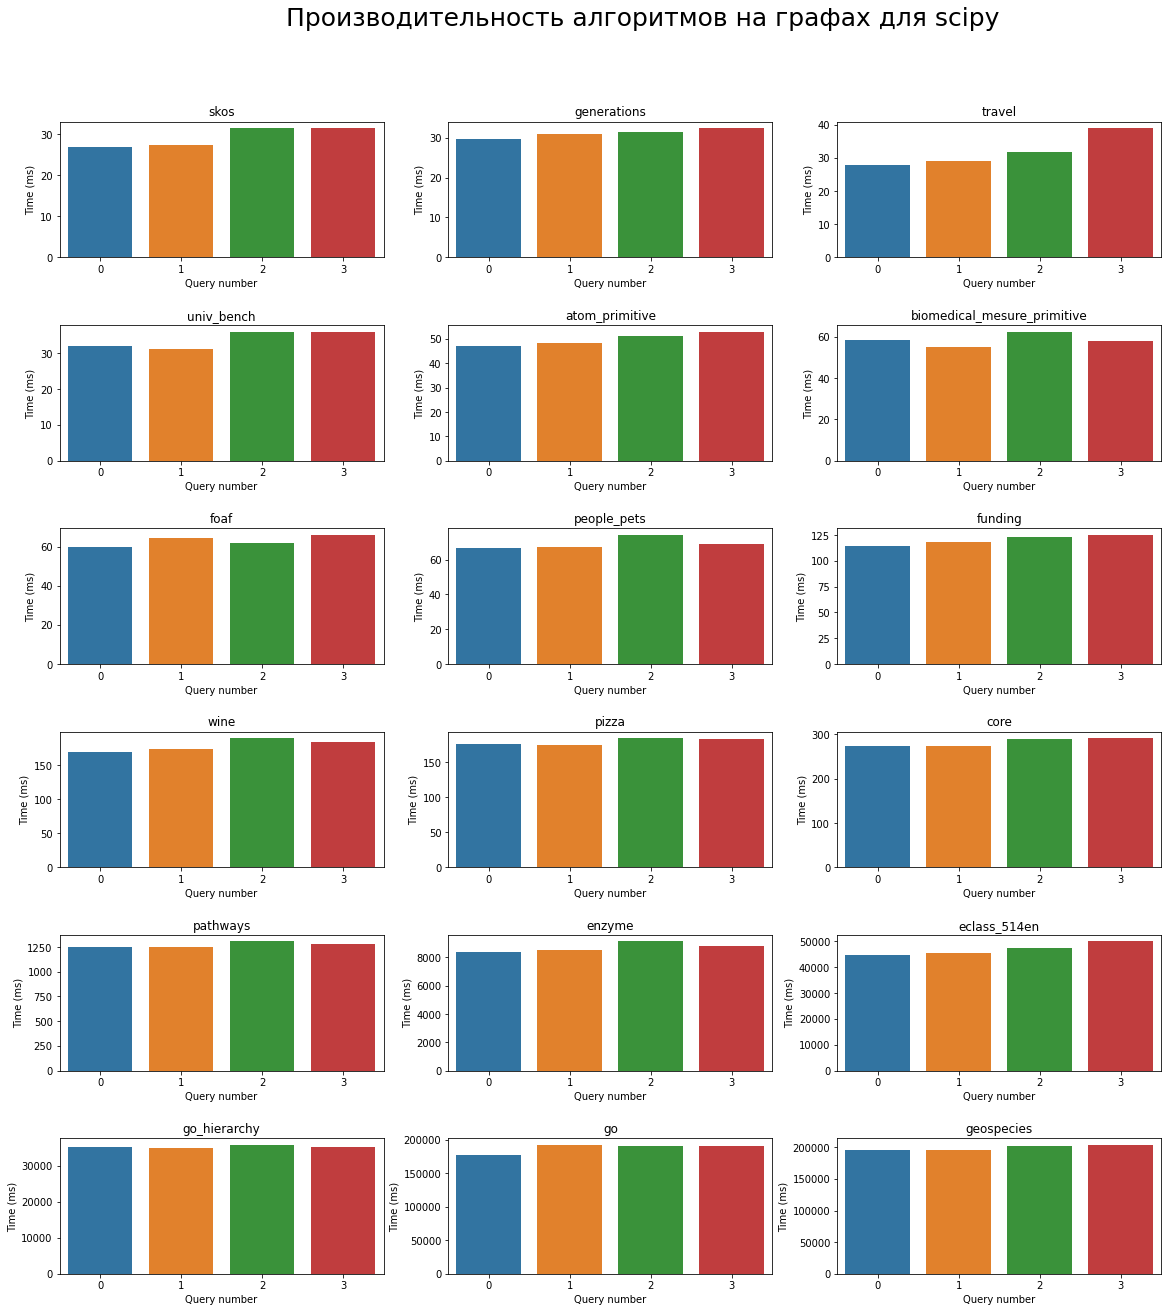

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(6, 3, figsize=(18, 20))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Производительность алгоритмов на графах для scipy', fontsize=25)

for i, name in enumerate(GRAPHS):
  ax = sns.barplot(ax=axes[i // 3, i % 3], data=df_scipy_res, x=df_scipy_res.index, y=name)
  ax.set_title(name)
  ax.set(title=name, ylabel="Time (ms)", xlabel="Query number")

### Количество времени на каждый запрос для каждого графа для pycubool

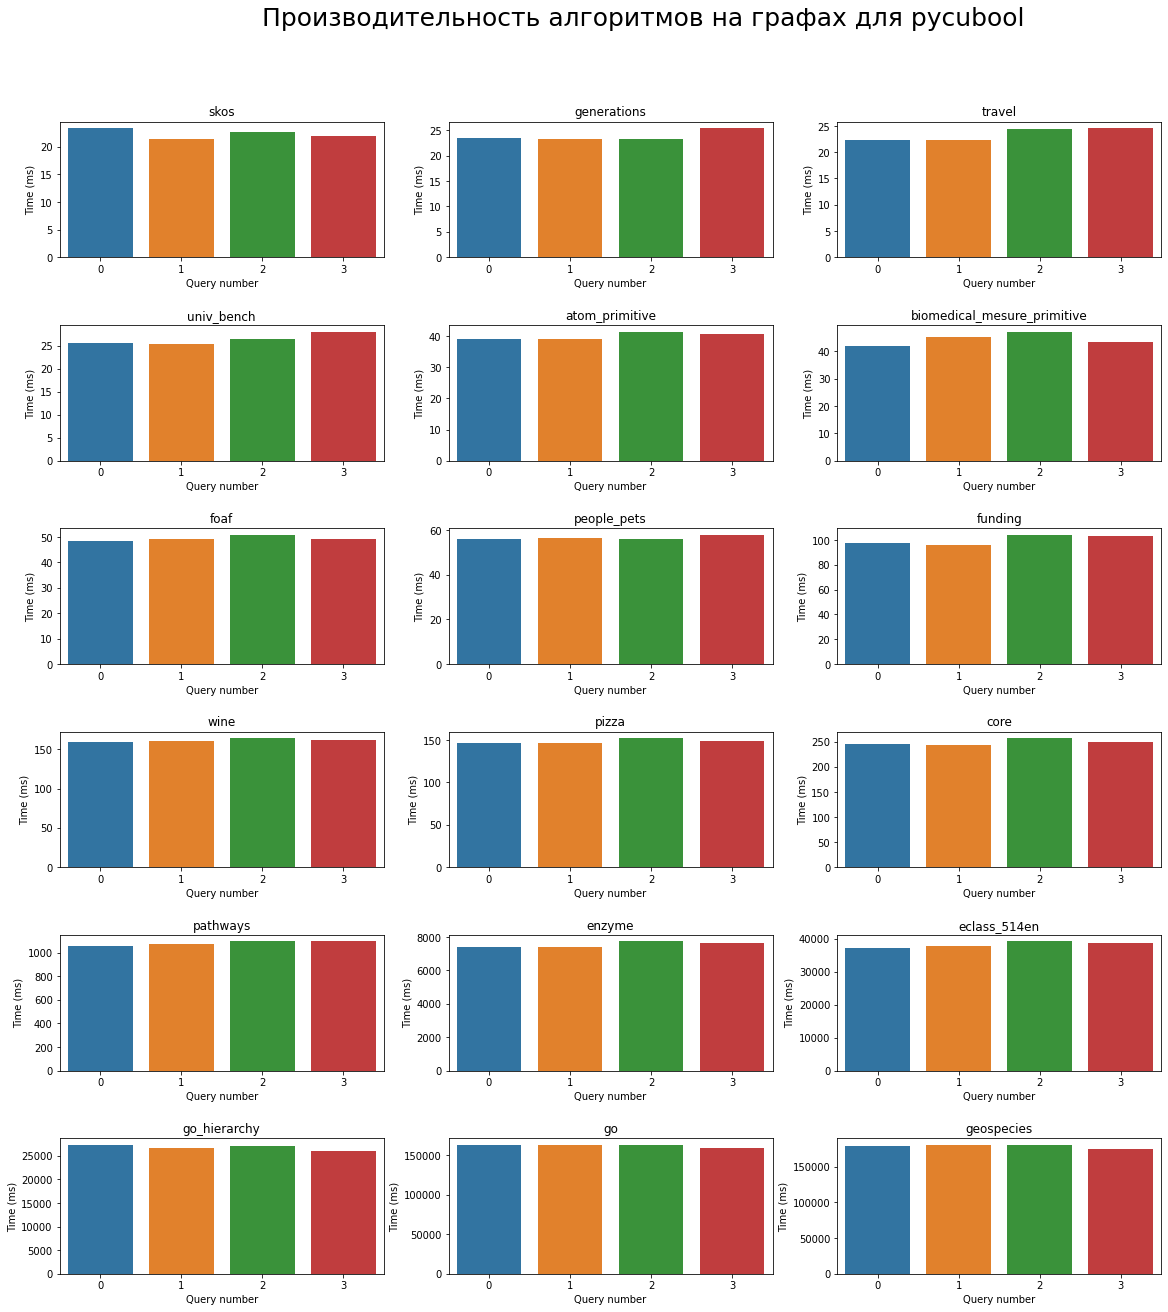

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(6, 3, figsize=(18, 20))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Производительность алгоритмов на графах для pycubool', fontsize=25)

for i, name in enumerate(GRAPHS):
  ax = sns.barplot(ax=axes[i // 3, i % 3], data=df_pycubool_res, x=df_pycubool_res.index, y=name)
  ax.set_title(name)
  ax.set(title=name, ylabel="Time (ms)", xlabel="Query number")

Исходя из полученных данных и построенных таблиц и графиков, видно, что алгоритм, реализованный с использованием библиотеки **pycubool** показал лучшие результаты, нежели алгоритм, реализованный с использованием библиотеки **scipy.sparse**. Примечательно также, что "выигрыш", то есть разница по времени между двумя алгоритма в процентном соотношении составляет примерно 20%.

### Заключение

Как было уставновлено выше, алгоритм решения задачи $RPQ$ показал лучшие результаты в случае применения библиотеки *pycubool* для реализации операций с булевыми матрицами. Результат можно объяснить тем, что библиотека *pycubool* во внутренней реализации использует возможности *NVIDIA CUDA*. Цель исследования успешно достигнута.
